In [2]:
import os
import cv2
import keras
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy


# Load the dataset

In [3]:
df_path = r"C:\Users\Alaa\Downloads\Deep learning dataset-20240312T130014Z-001\Deep learning dataset"

In [4]:
# open the folder and check what's inside then print some details
train_datagen = ImageDataGenerator()
data = train_datagen.flow_from_directory(
    df_path,
    class_mode='categorical'
)

Found 585 images belonging to 24 classes.


In [5]:
# def unify_background(image, threshold=200):
#     # Apply thresholding to detect background pixels
#     _, binary_mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

#     # Invert the binary mask
#     binary_mask = cv2.bitwise_not(binary_mask)

#     # Find contours in the binary mask
#     contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Create a mask for the contours
#     contour_mask = np.zeros_like(image)
#     cv2.drawContours(contour_mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

#     # Replace background pixels with white using the contour mask
#     result = cv2.bitwise_and(image, contour_mask)
#     result[contour_mask == 0] = 255  # Set background pixels to white

#     return result


def load_data(dataset_path, target_size=(100, 100), background_color=(255, 255, 255), exclude_student_ids=None):
    all_images = []
    all_labels = []

    # Iterate through each folder
    for student_id in os.listdir(dataset_path):
        # Skip processing folders with excluded student IDs
        if exclude_student_ids and student_id in exclude_student_ids:
            continue
            
        student_folder_path = os.path.join(dataset_path, student_id)

        if os.path.isdir(student_folder_path):
            # inside each folder, there should be two subfolders: original and forged
            original_folder_path = os.path.join(student_folder_path, f"{student_id}_original")
            forged_folder_path = os.path.join(student_folder_path, f"{student_id}_forged")

            # checking if folders exist
            if os.path.exists(original_folder_path) and os.path.exists(forged_folder_path):
                
                # read images from the original folder
                for image_name in os.listdir(original_folder_path):
                    image_path = os.path.join(original_folder_path, image_name)
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, target_size)  # resizing the image 
                        all_images.append(img)
                        all_labels.append(student_id+"_original")

                # read images from the forged folder
                for image_name in os.listdir(forged_folder_path):
                    image_path = os.path.join(forged_folder_path, image_name)
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, target_size)  # resizing the image 
                        all_images.append(img)
                        all_labels.append(student_id+"_forged")

    # convert lists to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    return all_images, all_labels



In [6]:
exclude_student_ids = ["20217022"]
images, labels = load_data(df_path, exclude_student_ids=exclude_student_ids)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (497, 100, 100)
Labels shape: (497,)


# Display some of the original images

In [7]:
def display_images_with_labels(images, labels, num_images=5):
    # Select 5 random images to display
    img = np.random.choice(len(images), num_images, replace=False)

    # Plot images with labels
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(img):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

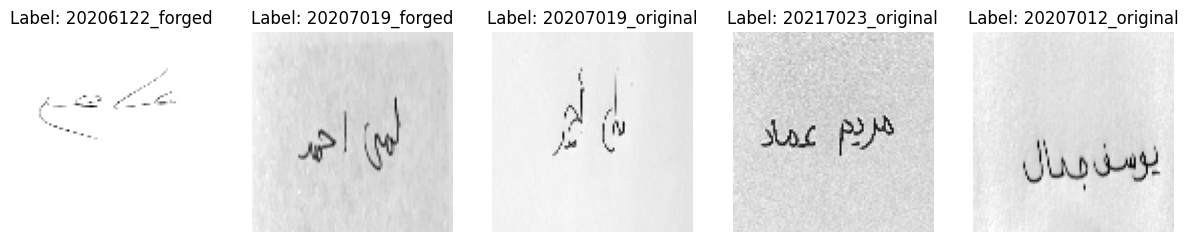

In [8]:
display_images_with_labels(images, labels)

# Generating the dataset for the Siamese Network

In [9]:
def generate_dataset(all_images, all_labels):
    X = []
    y = []
    
    classes = np.unique(all_labels)
    NUM_CLASSES = len(classes)
    #classes_original = [item for item in classes if 'original' in item]
    #classes_forged = [item for item in classes if 'forged' in item]

    class_images = []
    class_idx = {}
    
    for i in range(NUM_CLASSES):
        class_images += [(all_labels == classes[i]).nonzero()[0]]
        class_idx[classes[i]] = i
    
    #required_iterations = int(DATASET_SIZE / (len(all_images) * 2))    # does not work idk why
    required_iterations = 15
    
    for itr in range(required_iterations):
        for i in range(len(all_images)):
            # Generate an example (the original positive image)
            x1 = all_images[i]
            x1_lbl = all_labels[i]
            
            if 'original' in x1_lbl:
                # Generate a positive example
                # Choose a random image from the "original" folder of the same class
                x2_idx = random.choice(class_images[class_idx[x1_lbl]])
                x2 = all_images[x2_idx]
                X.append([x1, x2])
                y.append(1)
                
                # Generate a negative example
                # Choose a random image from the "forged" folder of the same student (by checking the ID first)
                student_id = x1_lbl.split('_')[0]
                forged_label = f"{student_id}_forged"
                x2_idx_forged = random.choice(class_images[class_idx[forged_label]])
                x2_forged = all_images[x2_idx_forged]
                X.append([x1, x2_forged])
                y.append(0)
        
    return np.array(X), np.array(y)

In [10]:
X, y = generate_dataset(images, labels)
print("Generated dataset shape:", X.shape)
print("Generated labels shape:", y.shape)

Generated dataset shape: (7920, 2, 100, 100)
Generated labels shape: (7920,)


# Display some samples from the generated data

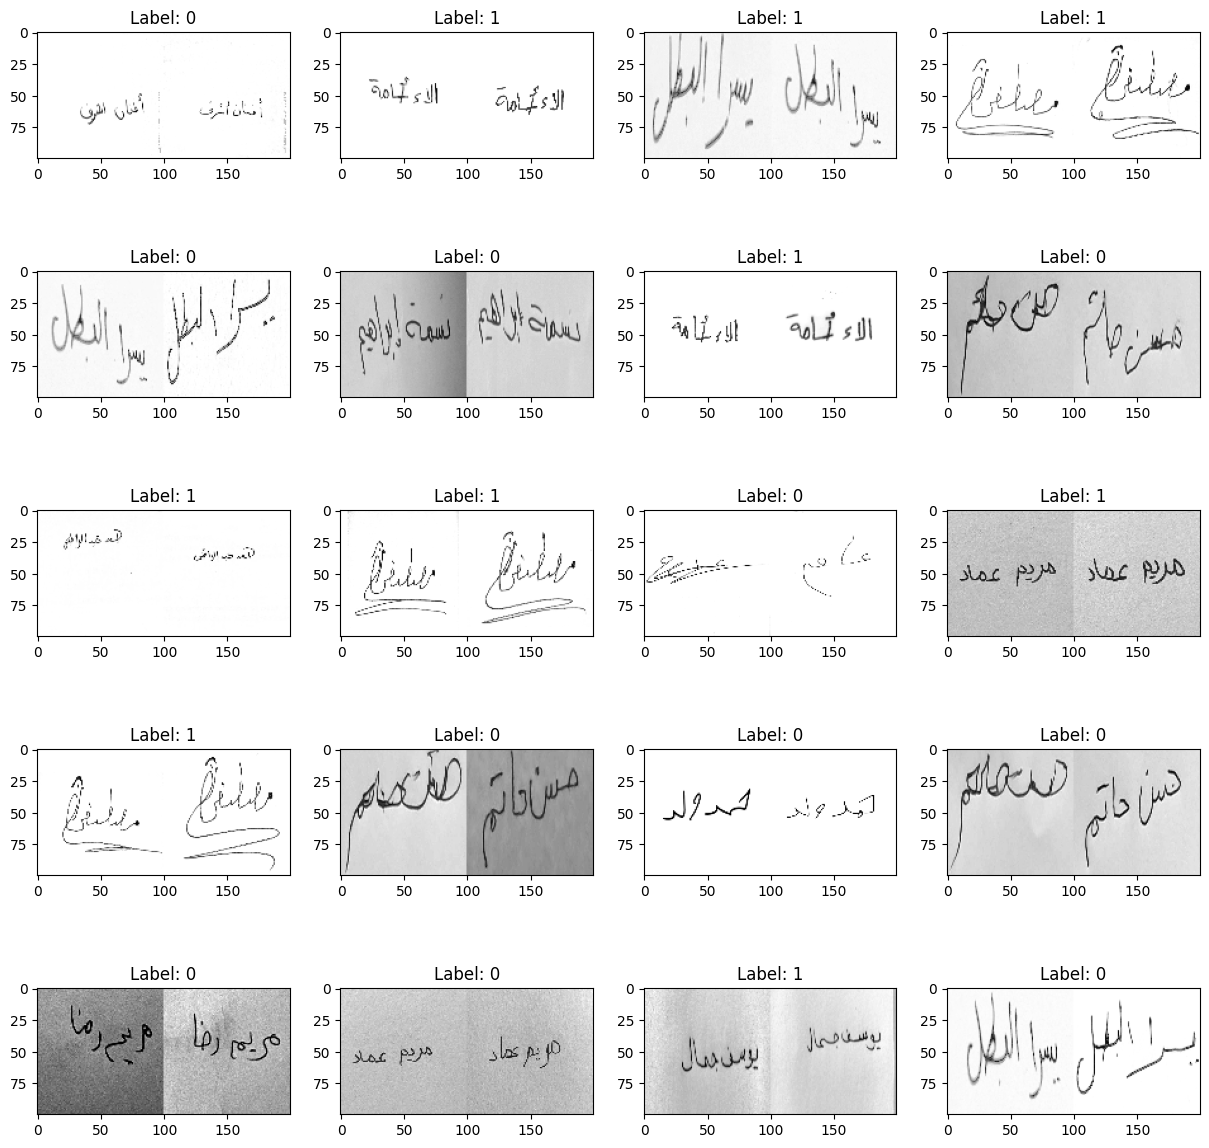

In [11]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15))

for i in range(20):
    ax = axes[i // 4, i % 4]
    img_idx = random.randint(0, len(X))
    concat_image = np.concatenate([X[img_idx][0], X[img_idx][1]], axis=1)
    ax.imshow(concat_image, cmap='gray')
    ax.set_title("Label: {}".format(y[img_idx]))

plt.show()

# Splitting the dataset into train and test sets

In [12]:
# # Assuming X contains your images and y contains the corresponding labels
# # Ensure both X and y have the same number of samples
# min_samples = min(X.shape[0], y.shape[0])
# X = X[:min_samples]
# y = y[:min_samples]

# # Reshape X to have shape (-1, 100, 100, 3) for images with 3 channels
# X = X.reshape((-1, 560, 560, 1))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))


print("y_train shape:", y_train)
# print("y_test shape:", y_test)

6336
6336
1584
1584
y_train shape: [1 1 1 ... 1 0 1]


# Building a Siamese Network model with binary cross-entropy as the loss function.

In [14]:
def embedding_network(in_shape):
    input_layer = keras.layers.Input(in_shape)
    x = keras.layers.BatchNormalization()(input_layer)
    
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    x = keras.layers.Flatten()(x)
    
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)  
    
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x) 
    
    return keras.Model(inputs=input_layer, outputs=x)


In [15]:
def SiameseNetwork(in_shape):
    # Define the twin networks using the embedding network
    input_1 = keras.layers.Input(in_shape)
    input_2 = keras.layers.Input(in_shape)
    # The siamese network shares weights between twin networks. So, we use the same embedding network for both networks.
    embedding_net_obj = embedding_network(in_shape)
    twin_1 = (embedding_net_obj)(input_1)
    twin_2 = (embedding_net_obj)(input_2)
    # Define the energy function
    def euclidean_distance(vectors):
        vector1, vector2 = vectors
        sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_square, K.epsilon()))
    # Merge the twin networks using the energy function
    merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([twin_1, twin_2])
    # Normalize and send to sigmoid (optional step)
    norm_layer = keras.layers.BatchNormalization()(merge_layer)
    output_layer = keras.layers.Dense(1, activation="sigmoid")(norm_layer)
    return keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [16]:
# import tensorflow as tf
# # from tensorflow.keras import backend as K
# from tensorflow.keras.losses import binary_crossentropy

# def loss():
#     def binary_crossentropy_loss(y_true, y_pred):
#         return binary_crossentropy(y_true, y_pred)  
#     return binary_crossentropy_loss


# @tf.keras.utils.register_keras_serializable(name='custom_accuracy')
# def custom_accuracy(y_true, y_pred):
#     return K.mean(K.equal(K.cast(y_true, 'float32'), K.cast(y_pred[:, 0] < 0.5, 'float32')))


# Training the model on the train set

In [17]:
img_shape = (100, 100, 1)
siamese_model = SiameseNetwork(img_shape)

siamese_model.compile(loss=binary_crossentropy, optimizer="adam", metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = siamese_model.fit([x_train[:, 0], x_train[:, 1]], y_train,
                            validation_data=([x_test[:, 0], x_test[:, 1]], y_test),
                            batch_size=128, epochs=25,
                            callbacks=[early_stopping])  





Epoch 1/25


50/50 [==============================] - 44s 842ms/step - loss: 0.7189 - accuracy: 0.5563 - val_loss: 0.7635 - val_accuracy: 0.4987
Epoch 2/25
50/50 [==============================] - 49s 991ms/step - loss: 0.5896 - accuracy: 0.6648 - val_loss: 0.8093 - val_accuracy: 0.4886
Epoch 3/25
50/50 [==============================] - 49s 976ms/step - loss: 0.4613 - accuracy: 0.8179 - val_loss: 0.9139 - val_accuracy: 0.4886
Epoch 4/25
50/50 [==============================] - 49s 984ms/step - loss: 0.3270 - accuracy: 0.9571 - val_loss: 0.9307 - val_accuracy: 0.4886
Epoch 5/25
50/50 [==============================] - 49s 979ms/step - loss: 0.2600 - accuracy: 0.9905 - val_loss: 0.6966 - val_accuracy: 0.4975
Epoch 6/25
50/50 [==============================] - 48s 971ms/step - loss: 0.2206 - accuracy: 0.9957 - val_loss: 0.4795 - val_accuracy: 0.6850
Epoch 7/25
50/50 [==============================] - 42s 842ms/step - loss: 0.1928 - accuracy: 0.9976 - val_loss: 0.3252 - val_accuracy: 0

# Evaluating the performance of the model

50/50 [==============================] - 2s 49ms/step - loss: 0.0993 - accuracy: 1.0000
Test loss, test accuracy: [0.09927880764007568, 1.0]
Accuracy: 1.0


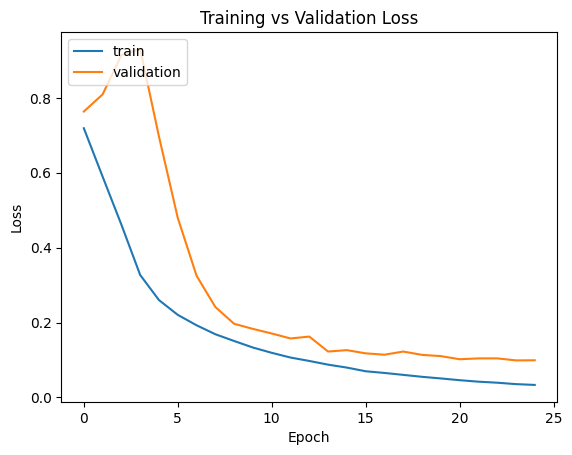

In [18]:
# Evaluate the model
results = siamese_model.evaluate([x_test[:, 0], x_test[:, 1]], y_test)
print("Test loss, test accuracy:", results)

accuracy = results[1]
print("Accuracy:", accuracy)

# Plot training vs validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "validation"], loc="upper left")
plt.title("Training vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


# Prediction

50/50 [==============================] - 3s 48ms/step


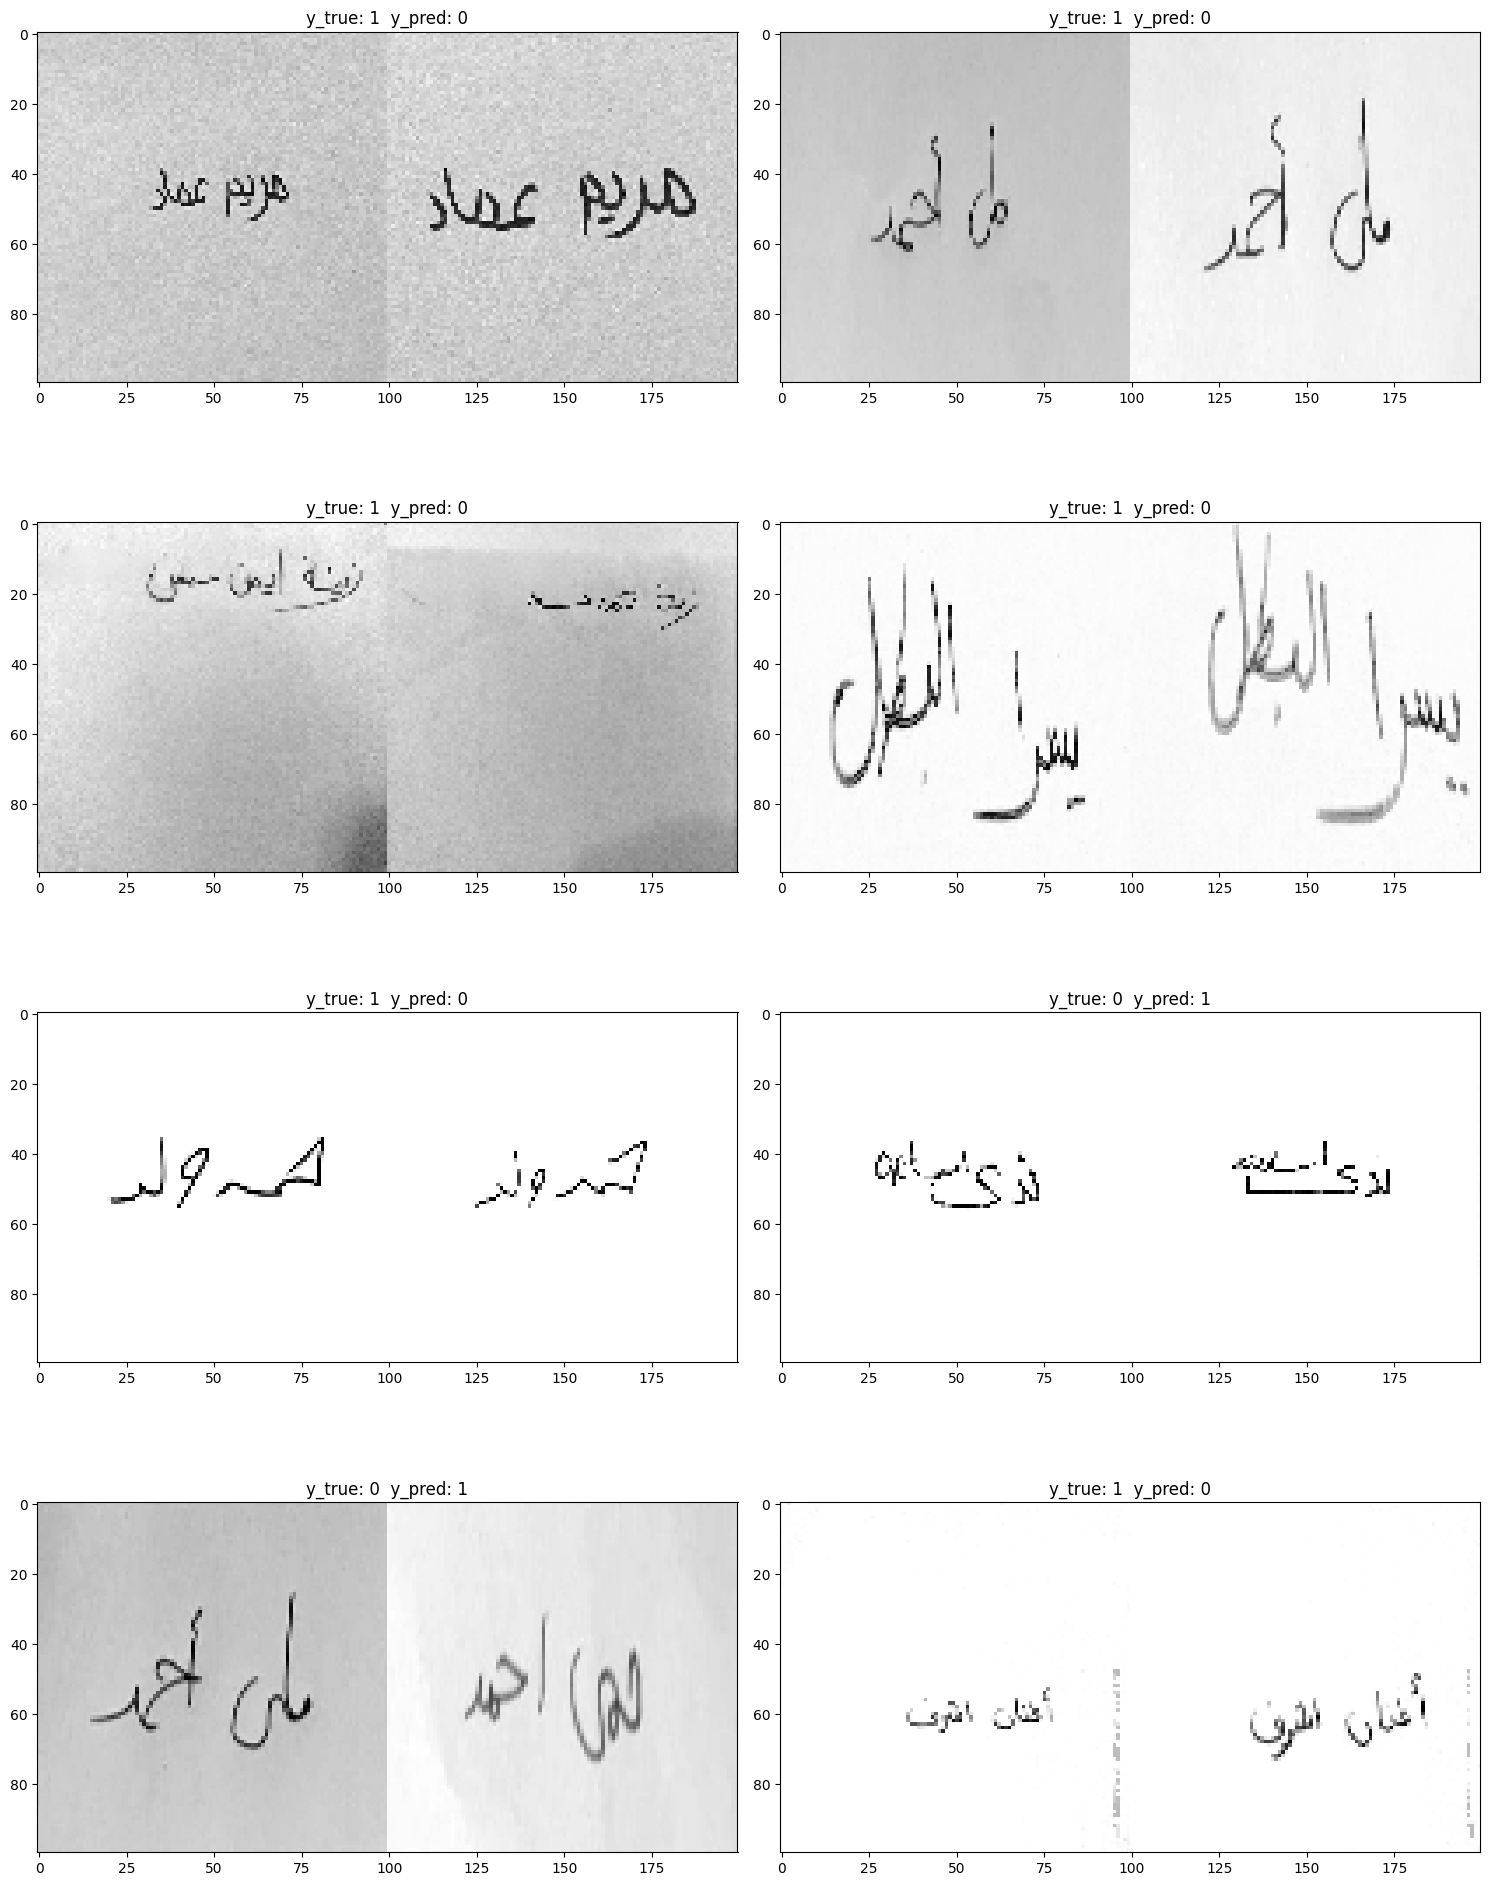

In [19]:
predictions = siamese_model.predict([x_test[:, 0], x_test[:, 1]])

fig, axes = plt.subplots(4, 2, figsize=(15, 20))  

for i in range(8):
    ax = axes[i // 2, i % 2]
    img_idx = random.randint(0, len(x_test) - 1)  
    
    concatenated_img = np.concatenate([x_test[img_idx, 0], x_test[img_idx, 1]], axis=1)
    ax.imshow(concatenated_img, cmap='gray')
    
    y_true = y_test[img_idx]
    y_pred = predictions[img_idx]
    ax.set_title("y_true: {}  y_pred: {}".format(y_true.item(), int(y_pred.item() < 0.5)))

plt.tight_layout()
plt.show()
